Here we generate a fake incompressible flow by using an abritrary streamfunction, we then use the Navier-Stokes equations and Tensorflow optimization to find the pressure

In [48]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


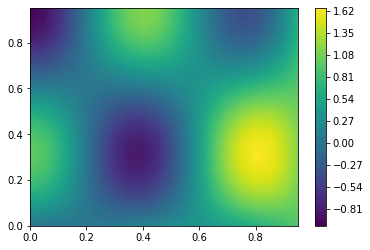

In [49]:
#generating grid
dx = 0.05
dz = 0.05

xx,zz = np.meshgrid(np.arange(0,1,dx),np.arange(0,1,dz))
nx = xx.shape[1]
nz = xx.shape[0]

n_grid = nx*nz #size of the non-boundary condition grid

#generating rarndom streamfunction field, psi
psi = np.cos(8*xx)*np.sin(5*zz) + xx**2

plt.contourf(xx,zz,psi,levels=100)
plt.colorbar()


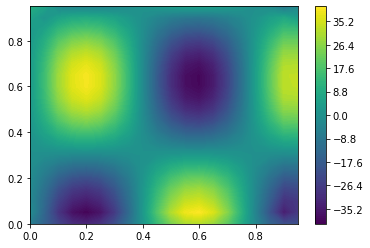

In [50]:
#defining scalar_field object that has both a piecewise representation and a weighted field representation
class scalar_field:
    def __init__(self,x_grid,z_grid,piecewise_data):
        #generating grid data
        self.piecewise_data = piecewise_data
        self.x_grid = x_grid
        self.z_grid = z_grid
        self.nx = x_grid.shape[1]
        self.nz = z_grid.shape[0]
        self.n_grid = self.nx*self.nz
        self.x_coord = x_grid.reshape((self.n_grid,1))
        self.z_coord = z_grid.reshape((self.n_grid,1))
        self.X_coord = np.stack((x_grid.flatten(),z_grid.flatten()) ).transpose() #vector of coordinates

        #converting into a weighted function i.e.
        #f(x,z) = \sum \phi_i(x,z) w_i
        self.epsilon = 1e-5 #term to overcome numerical error
        
        #defining radial distance:
        self.r2 = (self.x_coord-self.x_coord.transpose())**2 + (self.z_coord-self.z_coord.transpose())**2 +self.epsilon
        self.r = np.sqrt(self.r2)
        #thin-plate spline radial basis function:
        self.Phi = self.r2*np.log(self.r2)
        self.dPhidr = 2*self.r*(np.log(self.r2)+1)

        #solving matrix equation to find weights:
        self.weights = np.linalg.solve(self.Phi,piecewise_data.reshape((self.n_grid,1)) )

        #finding derivatives, lazy evaluation helps here as they are not calculated unless needed
        #df/dx = \dPhi/dr*dr/dr
        self.drdx = (self.x_coord - self.x_coord.transpose())/self.r
        self.drdz = (self.z_coord - self.z_coord.transpose())/self.r

        self.Phi_x = np.multiply(self.dPhidr,self.drdx)
        self.Phi_z = np.multiply(self.dPhidr,self.drdz)
        self.dPWDdx = np.matmul(np.multiply(self.dPhidr,self.drdx),self.weights).reshape((nz,nx)) #PWD: PieceWise Data
        self.dPWDdz = np.matmul(np.multiply(self.dPhidr,self.drdz),self.weights).reshape((nz,nx))

            
    def diff(self,variable):
        #differentiate scalar_field and create new scalar_field as the derivative
        if variable=='x':
            return scalar_field(self.x_grid,self.z_grid,self.dPWDdx)
        elif variable == 'z':
            return scalar_field(self.x_grid,self.z_grid,self.dPWDdz)
        else:
            raiseValueError("Must take derivative in either x or z directions")


    ###----Overloaded Operator functions----###

    #take care when using these function
    #todo add error checking such that the two field-variables have the same grid basis
    #if (self.grid ~= other.grid) then error


    def __add__(self,other):
        return scalar_field(self.x_grid,self.z_grid,self.piecewise_data + other.piecewise_data)

    def __sub__(self,other):
        return scalar_field(self.x_grid,self.z_grid,self.piecewise_data - other.piecewise_data)

    def __mul__(self,other):
        return scalar_field(self.x_grid,self.z_grid,np.multiply(self.piecewise_data,other.piecewise_data) )



    


#testing
psiSF = scalar_field(xx,zz,psi)
dpsidx = psiSF.diff(variable = 'x')
plt.contourf(xx,zz,dpsidx.dPWDdz,levels=100)
plt.colorbar()

Our equation now reads:

$\frac{\partial p}{\partial x} = -\frac{\partial u^2}{\partial x} -\frac{\partial uv}{\partial z} + Re^{-1} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial z^2} \right)$


$\frac{\partial p}{\partial z} = -\frac{\partial v^2}{\partial z} -\frac{\partial uv}{\partial v} + Re^{-1} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial z^2} \right)$

In [51]:
u = psiSF.diff('z')
v = scalar_field(xx,zz,-psiSF.dPWDdx)
Re = 10
dpdx = scalar_field(xx,zz, (u.diff('x').diff('x') + u.diff('z').diff('z')).piecewise_data/Re) - (u*u).diff('x') - (u*v).diff('z')
dpdz = scalar_field(xx,zz, (v.diff('x').diff('x') + v.diff('z').diff('z')).piecewise_data/Re) - (v*v).diff('z') - (u*v).diff('x')


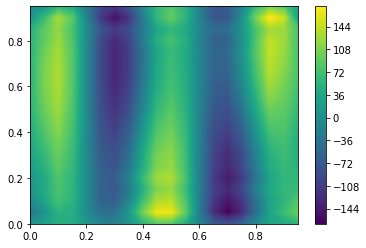

In [52]:
plt.contourf(xx,zz,dpdx.piecewise_data,levels=100)
plt.colorbar()

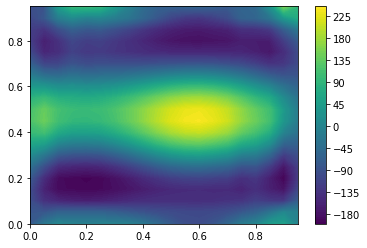

In [53]:
plt.contourf(xx,zz,dpdz.piecewise_data,levels=100)
plt.colorbar()

In [54]:
#generating tensorflow models for pressure:
#each column of our Phi RBF matrix is one piece of data
#[Phi_x]_i --> [Phi_x]_i \dot w --> dpdx

Phi_x = dpdx.Phi_x
Phi_z = dpdz.Phi_z 

#building a sequential model where the dot product of Phi_x and w_p is taken to produce dpdx
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer( input_shape=(dpdx.n_grid,) ),
    tf.keras.layers.Dense(1,use_bias = False)
])
#predictions = model(Phi_x).numpy()
#print(Phi_x[0:1,:])
#model(Phi_x[0:1,:]).numpy()
#model(Phi_x).numpy()


In [55]:
print(model(Phi_x).numpy())

[[ 0.3005765 ]
 [ 0.35100657]
 [ 0.43890965]
 [ 0.5823723 ]
 [ 0.7646117 ]
 [ 0.95245105]
 [ 1.1587304 ]
 [ 1.3641131 ]
 [ 1.5114594 ]
 [ 1.5546526 ]
 [ 1.5129566 ]
 [ 1.4046186 ]
 [ 1.2296915 ]
 [ 0.99751586]
 [ 0.68568665]
 [ 0.24500483]
 [-0.31025672]
 [-0.97644126]
 [-1.6831293 ]
 [-2.378692  ]
 [ 0.08211282]
 [ 0.15057684]
 [ 0.2476933 ]
 [ 0.42898846]
 [ 0.66884667]
 [ 0.89057666]
 [ 1.1220824 ]
 [ 1.3544767 ]
 [ 1.5138757 ]
 [ 1.5985508 ]
 [ 1.6131523 ]
 [ 1.5384912 ]
 [ 1.3895855 ]
 [ 1.1592865 ]
 [ 0.8365278 ]
 [ 0.40378165]
 [-0.13555801]
 [-0.80691636]
 [-1.5343472 ]
 [-2.2462566 ]
 [-0.12537381]
 [-0.06164169]
 [ 0.06230864]
 [ 0.29821762]
 [ 0.5880234 ]
 [ 0.82709134]
 [ 1.0617588 ]
 [ 1.298569  ]
 [ 1.4584615 ]
 [ 1.5778852 ]
 [ 1.6664646 ]
 [ 1.6383584 ]
 [ 1.5015994 ]
 [ 1.2662581 ]
 [ 0.9462362 ]
 [ 0.5223776 ]
 [-0.00896776]
 [-0.6651933 ]
 [-1.3984382 ]
 [-2.1205497 ]
 [-0.2990039 ]
 [-0.2620422 ]
 [-0.11244571]
 [ 0.16313739]
 [ 0.48335135]
 [ 0.75313115]
 [ 0.99205

In [56]:
#calculating loss function
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate = 10)
train_loss = tf.keras.metrics.Mean(name='train_loss')


In [57]:
@tf.function
def train_step(xx,yy):
    with tf.GradientTape() as tape:
        predictions = model(xx,training = True)
        loss = loss_fn(yy,predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    print(loss)

In [58]:
EPOCHS = 500
for epoch in range(EPOCHS):
    #train_loss.reset_states()
    train_step(Phi_x,dpdx.piecewise_data.reshape((dpdx.n_grid,1)))

    print(np.mean((model(Phi_x).numpy()-dpdx.piecewise_data.reshape((dpdx.n_grid,1)))**2)  )

Tensor("mean_squared_error/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("mean_squared_error/weighted_loss/value:0", shape=(), dtype=float32)
1351676.5229077064
91159.61755594812
351565.80525364773
759326.6286157349
521887.3147151199
155425.28894007986
73609.90589132074
235365.84991895617
344487.53968996817
271648.31710835575
129388.48315988276
66839.63046351033
111031.06644419287
170797.3700246778
161551.16883261604
93937.83608510364
40973.02609610767
49379.78932331845
93440.11592341594
112534.33079801296
81196.04717336493
30728.2713050375
9595.89210781963
31688.23918077687
64851.94438080743
69640.76837742416
41611.323380964815
10494.236284359806
4840.308085873816
23209.605153514804
40010.825772965516
36264.51562989602
18408.631738175958
6316.233922676436
9401.807301950133
18723.067128009043
20871.988296311858
14167.383696616744
7819.971389845401
8347.255051489235
12087.339681536818
11973.46956051886
7574.831977438794
4736.380426357908
6703.109421446632
9732.163247781089
878